# Check Common allele frequencies and how mistakes are distributed among Labs

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
import h5py
import itertools as it

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

Current machine: compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [2]:
def filter_reliable_snps(df, frac_cov=0.75, min_alt=50,
                        alt_col="altcount", tot_col="totcount", output=True):
    """Filter to reliable SNPs
    df: Input dataframe (allele spectrum)
    frac_cov: """
    max_count = np.max(df_spec[tot_col])  # Max. Coverage
    idx = (df[alt_col]>min_alt) & (df[tot_col]>(frac_cov*max_count))
    df = df[idx].copy()
    if output:
        print(f"Max Covered: {max_count} Inds")
        print(f"Cutoff: {frac_cov*max_count}")
        print(f"Filtered to {np.sum(idx)} / {len(idx)} Variants")
    return df

def load_h5(path = "./output/h5/covid_seqs.h5"):
    """Load and return HDF5"""
    f = h5py.File(path, "r") # Load for Sanity Check. See below!  
    print(f"Loaded HDF5 from {path}")
    print(list(f))
    print(np.shape(f["gt"]))
    assert(np.shape(f["gt"])[0]==len(f["samples"]))
    return f

def create_int_df(f, df_snps, h5_field="gt"):
    """Produce ref derived 0/1 counts for
    allele frequency file f and variant datafram df_snps"""
    n, _ = np.shape(f[h5_field])
    l = len(df_snps)
    gt = -np.ones((n,l), dtype="int8")
    g = f[h5_field][:, df_snps["pos"]]
    ref_idx = g == df_snps["ref"].astype('|S1').values[None,:]
    alt_idx = g == df_snps["alt"].astype('|S1').values[None,:]

    ## Sanity Checks
    assert(np.sum(ref_idx, axis=0)==df_snps["refcount"].values).all()
    assert(np.sum(alt_idx, axis=0)==df_snps["altcount"].values).all()

    gt[ref_idx]=0
    gt[alt_idx]=1
    return gt

# Load common alleles & clean data

In [3]:
path_spectrum = "./output/tables/allele_spectrum.tsv"

df_spec = pd.read_csv(path_spectrum, sep="\t")
print(f"Loaded {len(df_spec)} Loci Statistics from {path_spectrum}")
df_spec["totcount"] = (df_spec["refcount"] + df_spec["altcount"])  # Create the total Count
max_count = np.max(df_spec["totcount"])
print(f"Maximum Covered Locus: {max_count} Inds")

Loaded 29903 Loci Statistics from ./output/tables/allele_spectrum.tsv
Maximum Covered Locus: 4953 Inds


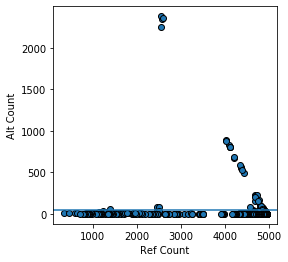

In [4]:
plt.figure(figsize=(4,4))
ax=plt.gca()
ax.scatter(df_spec["refcount"], df_spec["altcount"], ec='k')
ax.set_xlabel("Ref Count")
ax.set_ylabel("Alt Count")
ax.axhline(50)
#ax.set_xlim([2500,3300])
plt.show()

# Analyze SNPs on 0/1/-1 basis

In [5]:
df_snps = filter_reliable_snps(df_spec, frac_cov=0.75, min_alt=50)
f = load_h5(path = "./output/h5/covid_seqs.h5")

### Load relevant parts of the HDF5
gt = create_int_df(f, df_snps)  # Create 0/1 Genotype Matrix [n,l] for df_snps Positions
np.shape(gt)

Max Covered: 4953 Inds
Cutoff: 3714.75
Filtered to 47 / 29903 Variants
Loaded HDF5 from ./output/h5/covid_seqs.h5
['gt', 'samples']
(4954, 29903)


(4954, 47)

### Load the relevant parts of the hdf5

In [25]:
def return_der_stats(g1, g2, cov_only=True):
    """Calculate and return statistics
    of ancestral/derived.
    g1, g2: Arrays of Genotypes (0/1/-1)"""
    if cov_only:
        idx = (g1>=0) & (g2>=0)
        g1, g2 = g1[idx], g2[idx] 
    d1 = (g1 == 1)
    d2 = (g2 == 1)
    td1, td2 = np.sum(d1), np.sum(d2)  # How many are derived
    
    both_d = np.sum(d1 & d2)
    min_d = np.min([td1,td2])
    min_idx = np.argmin([td1,td2])
    
    return both_d, min_d, min_idx

def calc_pw_stats(gt):
    """Calculate pw. Loci statistics for Genotypes gt (n,l).
    Return Matrix of minimum derived allele, both_derived allele, and fraction"""
    assert(len(np.shape(gt))==2)  # Sanity Check if Genotype Matrix
    
    l = np.shape(gt)[1]
    both_ds, min_ds = np.zeros((l,l), dtype="int"), np.zeros((l,l),dtype="int")
    fracs = np.zeros((l,l),dtype="float")
    
    for (i1,i2) in it.combinations(range(l),2):
        both_d, min_d, min_idx = return_der_stats(gt[:,i1], gt[:,i2], cov_only=True)
        
        both_ds[i1,i2]=both_d
        min_ds[i1,i2]=min_d
    
    ### Mirror Values
    min_ds = min_ds + min_ds.T
    both_ds = both_ds + both_ds.T
        
    ### Do the Diagonal
    for i in range(l):
        min_ds[i,i] = np.sum(gt[:,i]*(gt[:,i]>=0))
        both_ds[i,i] = np.sum(gt[:,i]*(gt[:,i]>=0))
    assert(np.min(min_ds)>0)  # To make sure only derived Markers where in there
    fracs = both_ds / min_ds
    return both_ds, min_ds, fracs

In [26]:
both_ds, min_ds, fracs =calc_pw_stats(gt)

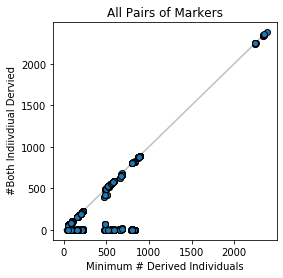

In [29]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(min_ds.flatten(), both_ds.flatten(), ec="k", zorder=1)
ax.set_xlabel("Minimum # Derived Individuals")
ax.set_ylabel(" #Both Indiivdiual Dervied")
ax.set_title("All Pairs of Markers")
m = np.max(min_ds)
ax.plot([0,m],[0,m], c="silver", zorder=0)
#ax.set_xlim([0,100])
#ax.set_ylim([0,100])
plt.show()

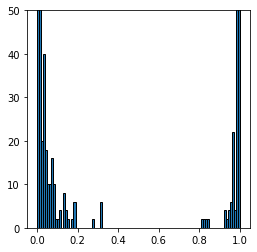

In [40]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.hist(fracs.flatten(), bins=100, ec="k")
ax.set_ylim([0,50])
plt.show()

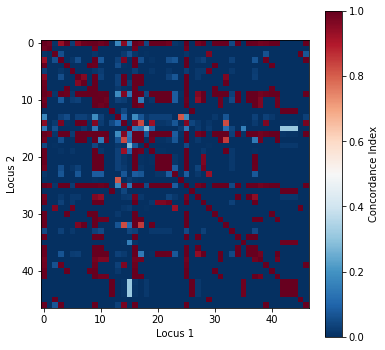

In [52]:
fig = plt.figure(figsize=(6,6))
ax=plt.gca()
#fig,, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=3)
pos = ax.imshow(fracs, cmap="RdBu_r")
fig.colorbar(pos, ax=ax, label="Concordance Index")
ax.set_xlabel("Locus 1")
ax.set_ylabel("Locus 2")
#fig.colorbar(pos, ax=ax1)
plt.show()

In [55]:
np.where((0.2<fracs) & (fracs < 0.8))

(array([15, 15, 15, 15, 18, 42, 43, 44]),
 array([18, 42, 43, 44, 15, 15, 15, 15]))

In [58]:
df_snps.iloc[15,:]

refcount     4636
altcount       51
ref             t
alt             g
pos         13401
totcount     4687
Name: 13401, dtype: object


# Area 51

In [63]:
df_snps.reset_index()[-10:]

,index,refcount,altcount,ref,alt,pos,totcount
37,28143,4030,880,t,c,28143,4910
38,28656,4856,63,c,t,28656,4919
39,28687,4830,94,t,c,28687,4924
40,28850,4766,156,g,t,28850,4922
41,28862,4860,64,c,t,28862,4924
42,28880,4111,802,g,a,28880,4913
43,28881,4118,800,g,a,28881,4918
44,28882,4118,800,g,c,28882,4918
45,29552,4840,53,g,a,29552,4893
46,29741,4573,83,g,t,29741,4656


In [71]:
np.sum(gt==1, axis=0)

array([1444,   70,  368,   86,  159,  101,  102,  156, 1470,  734,   54,
        476, 1472,  296,  117,  126,  498,  514,  532,   56,   96, 1482,
        468,   59,  355,  172,  724,   76,  114,  445,  444,  444,   53,
         67])

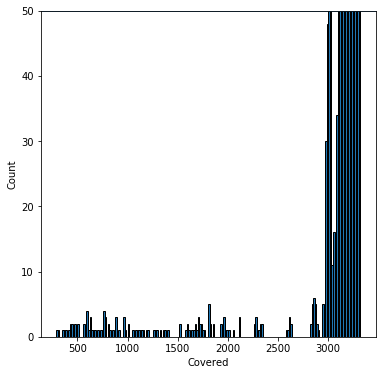

In [28]:
plt.figure(figsize=(6,6))
ax=plt.gca()
ax.hist(df_spec["totcount"], ec="k", bins=200)
ax.set_xlabel("Covered")
ax.set_ylabel("Count")
ax.axhline(50)
#ax.set_xlim([2500,3300])
ax.set_ylim([0,50])
plt.show()

### Test Loading hdf5

In [2]:
path="/home/np29/myhdf5/2bit_uchar.h5"
f = h5py.File(path, "r") # Load for Sanity Check. See below!  
print(f"Loaded HDF5 from {path}")
print(list(f))

Loaded HDF5 from /home/np29/myhdf5/2bit_uchar.h5
['2bit']


In [4]:
f["2bit"][:]

array([[0, 1],
       [2, 3],
       [0, 1]], dtype=uint8)

In [36]:
a = [0, 1, 1, 1, 0]
b= [0, 0, 1, 0, 0]

np.corrcoef(a,b)

array([[1.        , 0.40824829],
       [0.40824829, 1.        ]])